In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Passenger:
    def __init__(self,start_floor,end_floor,arrival_time):
        self.start_floor = start_floor
        self.end_floor = end_floor
        self.arrival_time = arrival_time
        if (start_floor - end_floor)<0:
            self.travel_direction = 'up'
        else:
            self.travel_direction = 'down'
            
    def __repr__(self):
        return ("Pasażer: " + " jedzie z " + str(self.start_floor) + 
                " na " +  str(self.end_floor) +" piętro")
    
    
class Lift:
    def __init__(self,max_lift_capacity=5):
        self.busy = 0 
        self.start_floor = 0
        self.end_floor = 0
        self.start_time = 0
        self.no_passengers = 0
        self.max_lift_capacitiy = max_lift_capacity
        self.travel_direction = None
        self.passenger_in_lift = [np.inf]
    def __repr__(self):
        if self.busy == 0:
            return ("Winda jest wolna")
        else:
            return ("Winda zaczęła podróż o " + str(self.start_time) 
                + " jedzie z " + str(self.start_floor) + 
                " na " +  str(self.end_floor) +" piętro, z " + str(self.no_passengers) + " pasażerami" )
        
    def set_direction(self):
        if (self.start_floor - self.end_floor)<0:
            self.travel_direction = 'up'
        else:
            self.travel_direction = 'down'

        
class Event:
    def __init__(self,event_type,event_time,passenger,lift):
        self.event_type = event_type
        self.event_time = event_time
        self.passenger = passenger
        self.lift = lift
    def __repr__(self):
        return ("Typ zdarzenia : " +self.event_type +" "+ str(self.passenger) + str(self.lift)
               + " czas " + str(self.event_time))

In [177]:

class Simulation:
    def __init__(self,lifts,floor_travel_time = 2,avg_arrival_time = 1,max_floors = 10):
        #słownik z kolejką oczekujących pasażerów wraz z ich startowymi i końcowymi piętrami
        self.waiting_passengers = []
        #definicja wind
        self.lifts = lifts
        self.floor_travel_time = floor_travel_time
        self.avg_arrival_time = avg_arrival_time
        self.max_floors = max_floors
        #czas kolejnego przybycia
        self.events = []
        self._generate_arrival(0)
        
        #statystyki
        self.n_handled = 0
        self.n_arrivals = 0 
        self.total_wait_time = 0.0
    
    def _get_random_floors(self):
        possible_floors = list(range(0,self.max_floors))
        start_floor = np.random.choice(possible_floors)
        possible_floors.remove(start_floor)
        end_floor = np.random.choice(possible_floors)
        return start_floor,end_floor
    
    def _service_time(self,start_floor,end_floor):
        return self.floor_travel_time*np.abs(start_floor-end_floor)
    def _generate_arrival(self,current_time):
        start_floor,end_floor = self._get_random_floors()
        next_arrival_time = current_time + np.random.exponential(self.avg_arrival_time)
        new_passenger = Passenger(start_floor,end_floor,next_arrival_time)
        self.events.append(Event("ARRIVAL",next_arrival_time,new_passenger,-1))
        
    def handle_arrival(self,event):
        '''
            Przybycie pasażera. Po pierwsze sprawdzane jest czy jest jakaś wolna winda.
            Jeśli tak to:
                - Ustawiamy status konkretnej windy na zajęty
                - Ustawiamy parametry windy, jak początkowe, końcowe piętro, i kierunek jazdy,liczbę pasażerów w windzie
                - Uaktualniamy czas zakończenia przejazdu danego pasażera
                - Uaktualniamy statystyki
            Jeśli winda jest zajęta to:
                - Sprawdzamy czy winda jedzie w tym samym kierunku, czy piętro pasażera jest pomiędzy obecnym
                przejazdem windy i czy czas dojazdu windy na pietro pasażera już nie minął 
                (winda przejechała dane piętro)
                    -Jeśli tak to zabieramy pasażera:
                        - Ustawiamy status konkretnej windy na zajęty
                        - Ustawiamy parametry windy, jak początkowe, 
                        końcowe piętro, i kierunek jazdy,liczbę pasażerów w windzie
                        - Uaktualniamy czas zakończenia przejazdu danego pasażera
                        - Dodajemy czas oczekiwania pasażea
                        - uaktualniamy statystyki
                    - Jeśli nie, dodajemy pasażera na kolejkę czekających pasażerów
                    - Liczymy czas przybycia kolejnego pasażera
        '''
        passenger = event.passenger
        passenger.arrival_time = event.event_time

        
        current_time = event.event_time
        if event.lift == -1:
            self.n_arrivals += 1
            self._generate_arrival(current_time)
        for lift in self.lifts:
            if lift.no_passengers<lift.max_lift_capacitiy:
                if not lift.busy:
                    lift.busy = 1
                    travel_time = self._service_time(passenger.start_floor,passenger.end_floor)
                    #winda na innym pietrze - czekamy
                    if lift.end_floor != passenger.start_floor:
                        wait_time = self._service_time(lift.end_floor,passenger.start_floor)
                        self.total_wait_time += wait_time
                        leaving_time = current_time + wait_time + travel_time
                        self.events.append(Event("LEAVING",leaving_time,passenger,lift))
                        lift.start_time = current_time + wait_time
                    else:
                        leaving_time = current_time + travel_time
                        self.events.append(Event("LEAVING",leaving_time,passenger,lift))
                        lift.start_time = current_time

                    lift.start_floor = passenger.start_floor 
                    lift.end_floor = passenger.end_floor 
                    lift.set_direction()

                    lift.no_passengers += 1

                    return
                #winda zajęta może zabierać pasażerów po drodze
                else:
                    #czas przejazdu windy na piętro paażera
                    travel_time_to_passenger = self._service_time(lift.start_floor,passenger.start_floor)
                    time_on_passenger_floor = lift.start_time +  travel_time_to_passenger    
                    take_passenger = ((lift.start_floor < passenger.start_floor < lift.end_floor) &
                                      (lift.travel_direction == passenger.travel_direction) &
                                      (time_on_passenger_floor > current_time))
                    if take_passenger:
                        #czas znalezienia się windy na pietrze - czas przybycia klienta
                        wait_time = time_on_passenger_floor - current_time 
                        self.total_wait_time += wait_time
                        lift.start_time = current_time + wait_time
                        travel_time = self._service_time(passenger.start_floor,passenger.end_floor)

                        leaving_time = current_time + wait_time + travel_time
                        self.events.append(Event("LEAVING", leaving_time,passenger,lift))

                        if lift.travel_direction =='up':
                            lift.end_floor = max(lift.end_floor,passenger.end_floor)
                        else:
                            lift.end_floor = min(lift.end_floor,passenger.end_floor)
                        lift.set_direction()

#                         if event.lift == -1:
#                             self._generate_arrival(current_time)
                        lift.no_passengers += 1
                        

                        return
        #nie zabraliśmy do windy, zwiększamy kolejkę oczekujących
        self.waiting_passengers.append(passenger)
#         self._generate_arrival(current_time)
#         print("Brak wolnej windy - trzeba czekać")
#         print("Liczba czekających pasażerów {}".format(self.waiting_passengers))
        
    def handle_leaving(self,event):
        
#         print("{} wysiada z windy {}".format(event.passenger,event.lift))
        self.n_handled += 1
        leaving_passenger = event.passenger
        lift = event.lift
        
        lift.no_passengers -= 1
        
        #Sprawdzenie czy ktoś jeszcze jest w windzie
        if lift.no_passengers == 0:
            lift.busy = 0
            if self.waiting_passengers:
                #dodaj do zdarzeń przyjście tego pana z czasem natychmiastowym i usun z oczekiwanych
                self.waiting_passengers.sort(key=lambda x:x.arrival_time)
                next_passenger = self.waiting_passengers[0]
                self.total_wait_time += (event.event_time - next_passenger.arrival_time)
                self.waiting_passengers.remove(next_passenger)
                self.events.append(Event("ARRIVAL", event.event_time,next_passenger,lift))

#             else:
#                 #jeśli nikt nie czeka zwalniamy daną windę 
#                 lift.busy = 0

    def simulate(self):
        t = 0
        ''' Główna symulacja, w której sprawdzamy jakie jest kolejne zdarzenie na liście
        i zgodnie z czym uaktualniamy symulacje '''
        horizon = 1*24*3600
        while t<horizon:
            next_event = min(self.events, key=lambda x: x.event_time)
            if next_event.event_type == "ARRIVAL":
                self.handle_arrival(next_event)
            elif next_event.event_type == "LEAVING":
                self.handle_leaving(next_event)
            self.events.remove(next_event)
            t = next_event.event_time
        #doliczamy czekających 
        for wp in self.waiting_passengers:
            self.total_wait_time += wp.arrival_time
        return self.total_wait_time,self.n_arrivals,self.n_handled


In [210]:
#definicja zmiennych
def make_simulation(n_lifts):
    avg_arrival_time = 5
    floor_travel_time = 10
    max_floors = 10
    lifts = [] 
    for lift in range(n_lifts):
        #Domyślnie wielkośc windy jest ustawiona na 5
        lifts.append(Lift(max_lift_capacity=15))
    s = Simulation(lifts,floor_travel_time = floor_travel_time,avg_arrival_time = avg_arrival_time,
                   max_floors=max_floors)
    return s.simulate()


In [211]:
avg_times = []
lefts = []
arrivals = []
for it in range(1,11):
    total_time,arrival,left = make_simulation(it)
    lefts.append(left)
    arrivals.append(arrival)
    
    avg_times.append(total_time/arrival)

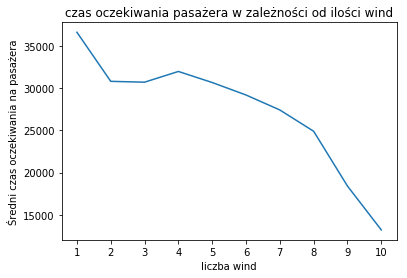

In [212]:
# list(range(len(avg_times))
x = range(1,len(avg_times)+1)
plt.plot(x,avg_times)
plt.title("czas oczekiwania pasażera w zależności od ilości wind")
plt.xlabel("liczba wind")
plt.ylabel("Średni czas oczekiwania na pasażera")
plt.xticks(x)
pass

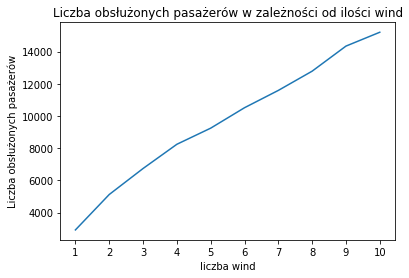

In [208]:
plt.title("Liczba obsłużonych pasażerów w zależności od ilości wind")
plt.xlabel("liczba wind")
plt.ylabel("Liczba obsłużonych pasażerów")
plt.xticks(x)
plt.plot(x,lefts)

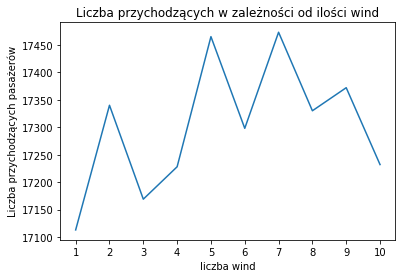

In [209]:
plt.title("Liczba przychodzących w zależności od ilości wind")
plt.xlabel("liczba wind")
plt.ylabel("Liczba przychodzących pasażerów")
plt.xticks(x)
plt.plot(x,arrivals)